**"Bayesian adaptive prior, is that you?": Comparing different approaches of mixed effects modeling**

For a while, I've wondered about the different approches for multilevel modeling, also known as mixed effects modeling. I have a Bayesian perspective as my understanding since I learned about it first from Statistical Rethinking. But when hearing others talk about "fixed effects", "varying effects", and "mixed effects", I had trouble connecting my understanding of the concept to theirs. Even more perplexing, I wasn't sure what the *source(s)* of the differences were:
- It it a frequentist vs. Bayesian thing?
- Is it a statistical package thing?
- Is it because there are five different definitions of "fixed and random effects", [infamously observed by Andrew Gelman](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and why he avoids using those terms?

I decided to take a deep dive, with much help from numerous sources. Please check out the [Acknowledgments](#acknowledgements)!

In this post, I'll be comparing across statistical philosophies and across statistical languages. 


| method | approach  |  language | package |
| -- |-- | ------ | ----- |
| 1 | frequentist  |  R | `lme4` | 
| 2 | Bayesian  |  Python | `pymc` | 

In [1]:
from aesara import tensor as at   # needs to be fixed in repo
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

In [3]:
# Enable running of R code
%load_ext rpy2.ipython

In [6]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(lme4))
suppressMessages(library(arm))
suppressMessages(library(merTools))

# Create synthetic `cafe` dataset.

Here's a brief description of the dataset from McElreath's book:
> Begin by defining the population of cafés that the robot might visit. This means we’ll define the average wait time in the morning and the afternoon, as well as the correlation between them. These numbers are sufficient to define the average properties of the cafés. Let’s define these properties, then we’ll sample cafés from them.

Nearly all code here is taken from the [Statistical Rethinking pymc repo](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) some minor alterations.

In [13]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)  # covariance matrix

N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

Now simulate the observations.

In [14]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
df_cafes = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
df_cafes.head()

,cafe,afternoon,wait
0,0,0,2.543644
1,0,1,2.794350
2,0,0,2.081509
3,0,1,1.935463
4,0,0,1.798565


Now that we have the dataset, we can run the two models, one with `lmer` and one with `pymc`. Here are the two equations.

**Equation form 1 (explicit fixed and varying effects terms in linear model)**

Various sources (including [Wikipedia](https://en.wikipedia.org/wiki/Mixed_model)) describe a linear mixed model with an equation like this.

$$ \textbf{y}_i = \textbf{X}_i \boldsymbol{\beta} + \textbf{Z}_i \textbf{b}_i + \boldsymbol{\epsilon}  \tag{1}$$

The left side of the equation represents our observations (or the wait time in the cafe example). The $\boldsymbol{\beta}$ in the first term of the equation represents a vector of coefficients across the population of cafes. These are the fixed effects. The $\textbf{b}_i$ in the second term of equation 1 represents a vector of coefficients for *each individual cafe*. These are the random (or varying) effects. Both $\textbf{X}_i$ and $\textbf{Z}_i$ are the design matrix of covariates in a general sense but in this case they are both vectors. Specifically, in this example, the values are the same between both kinds of vectors. The role of the subscript "i" is to highlight how there are values for each observation.

Since we only have one covariate (`afternoon`), equation 1 can be written simply in alternative form as equation 2. It might make it easier to understand. The notation will start to get hairy with subscripts and so I will explicitly re-name each individual element of the vector $\boldsymbol{\beta}$ (which one might call $\beta_0$ and $\beta_1$) to $\alpha$ and $\beta$. You can think of $\alpha$ and $\beta$ as a slope and intercept.

$$ y_i = (\alpha + \beta \times d_i) + (\alpha_i + \beta_{i} \times d_i) + \epsilon_i \tag{2} $$

In this equation, I have segmented the fixed and random effects with parentheses. 

**Equation form 2 (MVN, fixed effects as an adaptive prior)**

$$ W_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{i} + \beta_{i} \times A_{i} $$
$$ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \textbf{S} \right) $$
$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} $$
$$ \bar{\alpha} \sim \text{Normal}(0, 2) $$  
$$ \bar{\beta} \sim \text{Normal}(-1, 0.5) $$  
$$ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $$
$$ \textbf{R} \sim \text{LKJCorr}(2) $$

# Visualize data

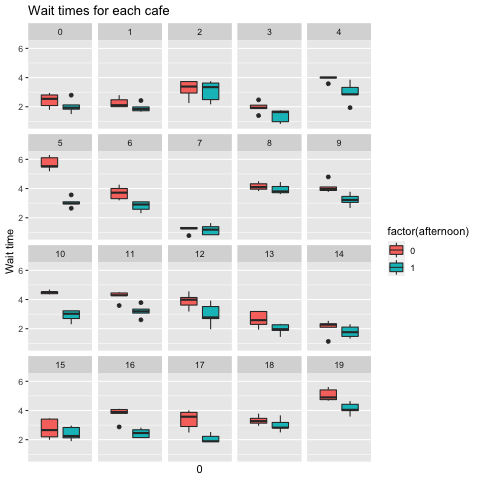

In [16]:
%%R -i df_cafes

# credit to TJ Mahr for a template of this code
xlab <- "Afternoon"
ylab <- "Wait time"
titlelab <- "Wait times for each cafe"

ggplot(df_cafes) + 
  aes(x = afternoon, y = wait) + 
  geom_boxplot(aes(fill=factor(afternoon))) +
  facet_wrap("cafe") +
  #scale_x_discrete(c(0,1)) +
  labs(x = xlab, y = ylab, title=titlelab)

# Common definitions and examples of mixed effects modeling

The first equation has an explicit fixed effects term and varying effects term in the linear model (second line). The fixed and varying effects are the first and second parenthetical blocks, respectively.

In the second equation, the linear model is already "mixed". It contains both the fixed and varying effects terms implicitly. The fixed effects estimates can be seen in the third line.

**Equation form 1 (explicit fixed and varying effects terms in linear model)**

$$ R \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = (\alpha + \beta \times d) + (\alpha_{[s]} + \beta_{[s]} \times d_{[s]}) $$

To run it in a Bayesian way, you can add this:
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \alpha_{[s]} \sim \text{Normal}(0, \sigma) $$
$$ \beta \sim \text{Normal}(0, 2) $$
$$ \beta_{[s]} \sim \text{Normal}(0, \sigma_{[s]}) $$
$$ \sigma \sim \text{Exp}(1) $$

**Equation form 2 (MVN, fixed effects as an adaptive prior)**

$$ R_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha_{i} + \beta_{i} \times d_{i} $$
$$ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}\bar{\alpha} \\ \bar{\beta} \end{bmatrix} , \textbf{S} \right) $$
$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} $$
$$ \bar{\alpha}, \bar{\beta} \sim \text{Normal}(0, 2) $$  
$$ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $$
$$ \textbf{R} \sim \text{LKJCorr}(2) $$

Let's run both equations.

In [ ]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,3.052724
1,0,1,1.565300
2,0,0,2.833480
3,0,1,1.362288
4,0,0,3.417140


# Equation form 1 (frequentist)

The `lmer` and by extension (`brms`) syntax was confusing to me. Thanks to @probot from the Discord channel for helping me understand this.

`lmer(Reaction ~ 1 + Days + (1 + Days | Subject), df_cafes)`

The `1` corresponds to inclusion of the intercept term. A `0` would exclude it. The `1 + Days` corresponds to the "fixed effects" portion of the model ($\alpha + \beta \times d$) while the `(1 + Days | Subject)` is the "varying effects" ($\alpha_{[s]} + \beta_{[s]} \times d_{[s]}$).

In [19]:
%%R -i df_cafes -o m

m <- lmer(wait ~ 1 + afternoon + (1 + afternoon | cafe), df_cafes)
arm::display(m)

lmer(formula = wait ~ 1 + afternoon + (1 + afternoon | cafe), 
    data = df_cafes)
            coef.est coef.se
(Intercept)  3.45     0.18  
afternoon   -0.88     0.11  

Error terms:
 Groups   Name        Std.Dev. Corr  
 cafe     (Intercept) 0.76           
          afternoon   0.40     -0.27 
 Residual             0.50           
---
number of obs: 200, groups: cafe, 20
AIC = 388, DIC = 367.4
deviance = 371.7 


Can we get the partial pooling results from the `lmer` output and see how it compares with the unpooled estimates?

In [38]:
%%R -i m -o df_partial_pooling -o random_sims

# Make a dataframe with the fitted effects
df_partial_pooling <- coef(m)[["cafe"]] %>% 
  rownames_to_column("cafe") %>% 
  as_tibble() %>% 
  rename(Intercept = `(Intercept)`, Slope_Days = afternoon) %>% 
  add_column(Model = "Partial pooling")

# head(df_partial_pooling)
# coef(m)$cafe

# estimate confidence interval
random_sims <- REsim(m, n.sims = 1000)
#plotREsim(random_sims)

In [37]:
random_sims

,groupFctr,groupID,term,mean,median,sd
1,cafe,0,(Intercept),-0.349610,-0.352130,0.299297
2,cafe,1,(Intercept),0.418064,0.420901,0.280791
3,cafe,2,(Intercept),0.120684,0.115471,0.278968
4,cafe,3,(Intercept),0.639215,0.644342,0.288686
5,cafe,4,(Intercept),-0.310616,-0.315338,0.290550
6,cafe,5,(Intercept),0.025144,0.025905,0.293921
7,cafe,6,(Intercept),0.887264,0.885110,0.295328
8,cafe,7,(Intercept),-1.514135,-1.522981,0.299355
9,cafe,8,(Intercept),-0.600425,-0.597196,0.288592
10,cafe,9,(Intercept),-1.131781,-1.142506,0.293113


OK, now let's try the Bayesian approach and compare answers.

# Equation form 2 (Bayesian)

In [11]:
n_cafes = df_cafes['cafe'].nunique()
cafe_idx = pd.Categorical(df_cafes["cafe"]).codes

with pm.Model() as m14_1:
    # can't specify a separate sigma_a and sigma_b for sd_dist but they're equivalent here
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    # needs to be fixed in repo sd > sigma
    a_bar = pm.Normal("a_bar", mu=5, sigma=2.0)  # prior for average intercept
    b_bar = pm.Normal("b_bar", mu=-1, sigma=0.5)  # prior for average slope

    # needs to be fixed in repo tt.stack > at.stack
    ab_subject = pm.MvNormal(
        "ab_subject", mu=at.stack([a_bar, b_bar]), chol=chol, shape=(n_cafes, 2)
    )  # population of varying effects
    # shape needs to be (n_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_subject[cafe_idx, 0] + ab_subject[cafe_idx, 1] * df_cafes["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes (in the top line)

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=df_cafes["wait"].values)  # likelihood

    idata_m14_1 = pm.sample(1000, target_accept=0.9)


/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your di

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


In [14]:
# take a glimpse at the head and tail of the summary table
pd.concat(
    [
        az.summary(idata_m14_1).head(10),
        az.summary(idata_m14_1).tail(10)
    ]
)

/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/blacar/opt/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.469,0.189,3.125,3.823,0.003,0.002,4888.0,2940.0,1.0
b_bar,-0.892,0.111,-1.102,-0.682,0.002,0.001,3560.0,3053.0,1.0
"ab_subject[0, 0]",3.095,0.200,2.702,3.455,0.003,0.002,4279.0,3114.0,1.0
"ab_subject[0, 1]",-1.226,0.255,-1.705,-0.765,0.005,0.003,3066.0,3406.0,1.0
"ab_subject[1, 0]",3.855,0.199,3.475,4.220,0.003,0.002,4939.0,2803.0,1.0
"ab_subject[1, 1]",-0.956,0.246,-1.414,-0.501,0.004,0.003,4428.0,3236.0,1.0
"ab_subject[2, 0]",3.544,0.198,3.167,3.916,0.003,0.002,4400.0,3390.0,1.0
"ab_subject[2, 1]",-1.223,0.255,-1.713,-0.752,0.004,0.003,3432.0,3429.0,1.0
"ab_subject[3, 0]",4.075,0.197,3.708,4.453,0.003,0.002,5305.0,3413.0,1.0
"ab_subject[3, 1]",-0.766,0.245,-1.221,-0.291,0.004,0.003,4244.0,2944.0,1.0


In [16]:
df_summary_int_and_slope = az.summary(idata_m14_1, var_names=['a_bar', 'b_bar'])
df_summary_int_and_slope

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.469,0.189,3.125,3.823,0.003,0.002,4888.0,2940.0,1.0
b_bar,-0.892,0.111,-1.102,-0.682,0.002,0.001,3560.0,3053.0,1.0


This compares well with the `lmer` output above.

```         
            coef.est coef.se
(Intercept)  3.45     0.18  
afternoon   -0.88     0.11  
```

In [41]:
df_summary_int_and_slope_cafes = az.summary(idata_m14_1, var_names=['ab_subject'])
df_summary_int_and_slope_cafes.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ab_subject[0, 0]",3.095,0.200,2.702,3.455,0.003,0.002,4279.0,3114.0,1.0
"ab_subject[0, 1]",-1.226,0.255,-1.705,-0.765,0.005,0.003,3066.0,3406.0,1.0
"ab_subject[1, 0]",3.855,0.199,3.475,4.220,0.003,0.002,4939.0,2803.0,1.0
"ab_subject[1, 1]",-0.956,0.246,-1.414,-0.501,0.004,0.003,4428.0,3236.0,1.0
"ab_subject[2, 0]",3.544,0.198,3.167,3.916,0.003,0.002,4400.0,3390.0,1.0


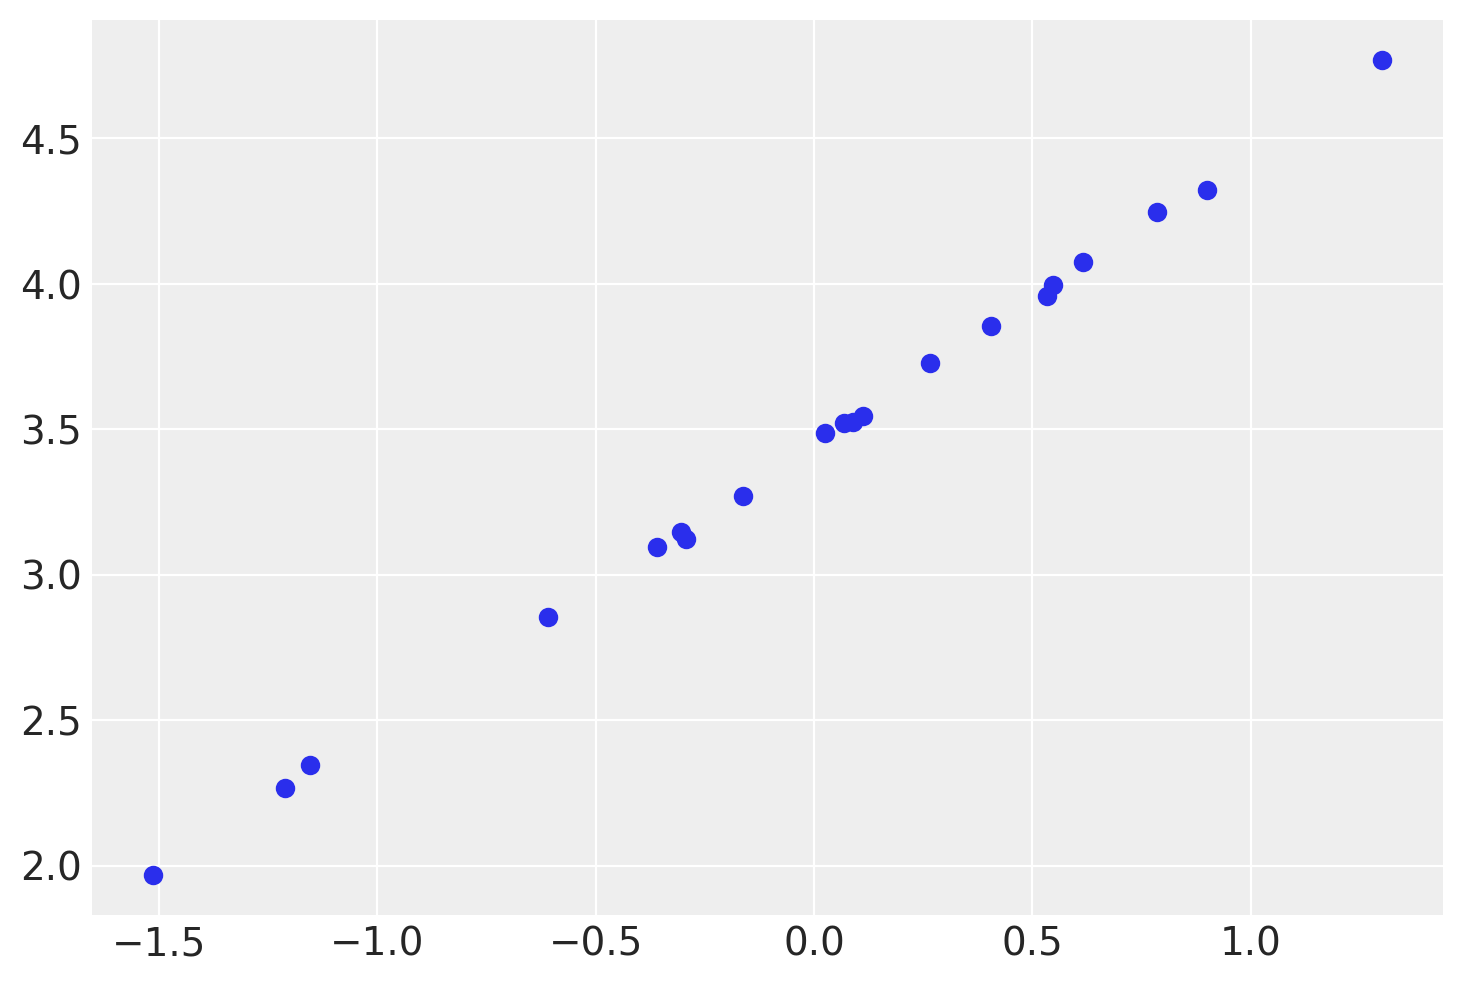

In [50]:
random_sims_int = random_sims.loc[random_sims['term']=='(Intercept)', 'mean'].copy()
random_sims_slope = random_sims.loc[random_sims['term']=='afternoon', 'mean'].copy()

bayesian_int = df_summary_int_and_slope_cafes.loc[df_summary_int_and_slope_cafes.index.str.contains(', 0\]'), 'mean']
bayesian_slope = df_summary_int_and_slope_cafes.loc[df_summary_int_and_slope_cafes.index.str.contains(', 1\]'), 'mean']

f, ax0 = plt.subplots()
# intercepts
ax0.scatter(random_sims_int, bayesian_int)

In [49]:
random_sims_int

,groupFctr,groupID,term,mean,median,sd
1,cafe,0,(Intercept),-0.359241,-0.360896,0.293384
2,cafe,1,(Intercept),0.406221,0.410760,0.290560
3,cafe,2,(Intercept),0.112589,0.116116,0.295527
4,cafe,3,(Intercept),0.616716,0.606907,0.300531
5,cafe,4,(Intercept),-0.305296,-0.296793,0.290784
6,cafe,5,(Intercept),0.025962,0.029718,0.291536
7,cafe,6,(Intercept),0.899481,0.902603,0.284866
8,cafe,7,(Intercept),-1.513998,-1.506516,0.288425
9,cafe,8,(Intercept),-0.609605,-0.617625,0.284043
10,cafe,9,(Intercept),-1.153484,-1.160221,0.292272


In [40]:
random_sims.head()

,groupFctr,groupID,term,mean,median,sd
1,cafe,0,(Intercept),-0.359241,-0.360896,0.293384
2,cafe,1,(Intercept),0.406221,0.410760,0.290560
3,cafe,2,(Intercept),0.112589,0.116116,0.295527
4,cafe,3,(Intercept),0.616716,0.606907,0.300531
5,cafe,4,(Intercept),-0.305296,-0.296793,0.290784


In [12]:
 # put in dataframe for easy access/manipulation
 idata_mB_df = idata_mB.to_dataframe()

 # obtain all posterior values and reverse standardize
a_bar_natural_scale = list()
b_bar_natural_scale = list()
for a_bar, b_bar in zip(idata_mB_df[('posterior', 'a_bar')], idata_mB_df[('posterior', 'b_bar')]):
    a_bar_natural_scale.append(reverse_standardize(a_bar, df_cafes, 'Reaction'))
    b_bar_natural_scale.append(reverse_standardize_slope(b_bar, df_cafes, 'Reaction'))

print(f"intercept (mean): {np.mean(a_bar_natural_scale):0.2f}, (std): {np.std(a_bar_natural_scale):0.2f}")
print(f"    slope (mean): {np.mean(b_bar_natural_scale):0.2f}, (std): {np.std(b_bar_natural_scale):0.2f}")

intercept (mean): 252.65, (std): 7.04
    slope (mean): 10.49, (std): 1.74


As we can see, they are very close to the numbers with the first approach.


Frequentist output
```
  coef.est coef.se
(Intercept) 252.54     6.43 
Days         10.45     1.54 
```

Look at `pymc4.ipynb` for other ideas for plots.

# Acknowledgements

- Eric J. Daza about some discussions about mixed effects modeling. It reminded me about improving my knowledge in this area.
- Richard McElreath's Statistical Rethinking for my introduction to Bayesian multilevel modeling.
- Statistical Rethinking repo.
- Andrzej Gałecki and Tomasz Burzykowski's [Linear Mixed-Effecsts Models Using R](https://link.springer.com/book/10.1007/978-1-4614-3900-4) which references the `lme4` package. McElreath actually referenced this package as a non-Bayesian alternative in his book.
- Andrew Gelman wrote about why he doesn't like using "fixed and random effects" (in a [blog](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and in a [paper](https://projecteuclid.org/journals/annals-of-statistics/volume-33/issue-1/Analysis-of-variancewhy-it-is-more-important-than-ever/10.1214/009053604000001048.full)).
- TJ Mahr's [partial pooling blog post](https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/).
- @probot from our Bayesian Discord channel.
- Thanks to the [`rpy2` package](https://rpy2.github.io/doc/latest/html/introduction.html) for allowing me to run R and Python code in the same notebook.

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Tue Aug 23 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.3.0

aesara: 2.7.9
aeppl : 0.0.27

matplotlib: 3.5.1
aesara    : 2.7.9
pymc      : 4.0.0b6
numpy     : 1.22.4
xarray    : 0.20.1
pandas    : 1.4.2
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
arviz     : 0.12.1

Watermark: 2.3.1



In [10]:
%%R
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Monterey 12.5

Matrix products: default
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] merTools_0.5.2  arm_1.12-2      MASS_7.3-57     lme4_1.1-30    
 [5] Matrix_1.4-1    forcats_0.5.2   stringr_1.4.1   dplyr_1.0.9    
 [9] purrr_0.3.4     readr_2.1.2     tidyr_1.2.0     tibble_3.1.8   
[13] ggplot2_3.3.6   tidyverse_1.3.2

loaded via a namespace (and not attached):
 [1] httr_1.4.4          jsonlite_1.8.0      splines_4.2.1      
 [4] foreach_1.5.2       modelr_0.1.9        shiny_1.7.2        
 [7] assertthat_0.2.1    broom.mixed_0.2.9.4 googlesheets4_1.0.1
[10] cellranger_1.1.0    globals_0.16.0      pillar_1.8.1       
[13] backports_1.4.1     lattice_0.20-45     glue_1.6.2         
[1